In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
file_list = os.listdir("/works/Data/Dacon/health_data_clf/")
file_list = [file for file in file_list if file.endswith(".csv")]
print(file_list)

['train_labels.csv', 'test_features.csv', 'train_features.csv', 'sample_submission.csv']


In [4]:
file_path = "/works/Data/Dacon/health_data_clf/"
train_label = pd.read_csv(file_path + file_list[0])
test_features = pd.read_csv(file_path + file_list[1])
train_features = pd.read_csv(file_path + file_list[2])
sample_submissuib = pd.read_csv(file_path + file_list[3])

print(train_label.shape)
print(test_features.shape)
print(train_features.shape)

(3125, 3)
(469200, 8)
(1875000, 8)


# Preprocessing data

1. Normalize
2. Oversampling

In [5]:
#Fourier, Oversampling
def preprocessing_data(input_set, label_set, over_count, need_col):
    
    df_filtered = input_set[["id"] + need_col].copy()
    new_input_set = np.array([])
    new_target_set = []
    
    #Nomarlize data
    for id_idx in range(df_filtered.id.min(),df_filtered.id.max()+1):
        if df_filtered[df_filtered.id==id_idx].shape[0]==0:
            continue
        
        for_normalize = df_filtered[need_col][df_filtered.id==id_idx].values.shape[0]
        transformed_data = np.fft.fft(df_filtered[need_col][df_filtered.id==id_idx].rolling(window=10).mean().values[9:],axis=0) / for_normalize
        transformed_data = np.abs(transformed_data)
        transformed_data = np.fft.fftshift(transformed_data)
        
        transformed_data = transformed_data.reshape(1,transformed_data.shape[0],transformed_data.shape[1])
        
        if len(new_input_set) == 0:
            new_input_set = transformed_data
        else:
            new_input_set = np.concatenate((new_input_set, transformed_data), axis=0)
        new_target_set.append(label_set[label_set.id==id_idx].label.values[0])
        
    #Make numpy array
    new_target_set = np.array(new_target_set).reshape(-1)
    print("Before split input_set : {} / target_set : {}".format(new_input_set.shape, new_target_set.shape))
    
    # Split data for trainning
    x_train, x_val, y_train, y_val = train_test_split(new_input_set, new_target_set, test_size=0.3, stratify=new_target_set)
    print("After split x_train : {} y_train : {} x_val : {} y_val : {}".format(x_train.shape, y_train.shape,
                                                                              x_val.shape, y_val.shape))
    
    #UpSampling
    add_array = np.zeros(shape=(1,x_train.shape[1],x_train.shape[2]))
    add_label = [-1]
    unique, counts = np.unique(y_train, return_counts=True)
    label_count = dict(zip(unique, counts))
    for key, val in label_count.items():
        if val < over_count:
            this_count = val
            while(this_count<over_count):
                #Extract data from 
                random_idx = np.random.randint(x_train[y_train == key].shape[0])
                start_idx = np.random.randint(191)
                extract_input_set = x_train[y_train == key][random_idx][start_idx:start_idx+400,:]

                add_random_idx = np.random.randint(x_train[y_train == 26].shape[0])
                for_adding_input_set = x_train[y_train == 26][add_random_idx][0:191,:]

                input_place = np.random.randint(2)
                if input_place == 0 :
                    add_input_set = np.concatenate((extract_input_set, for_adding_input_set), axis=0)
                else:
                    add_input_set = np.concatenate((for_adding_input_set, extract_input_set), axis=0)
                add_array = np.concatenate(
                    ( add_array, add_input_set.reshape(1,add_input_set.shape[0],add_input_set.shape[1]) ),
                    axis=0)
                this_count += 1
                add_label.append(key)
                
    add_array = add_array[1:]
    add_label = np.array(add_label[1:]).reshape(-1)
    
    #Merge
    x_train = np.concatenate((x_train, add_array), axis = 0)
    y_train = np.concatenate((y_train, add_label), axis = 0)
    print("After UpSampling x_train : {} y_train : {}".format(x_train.shape, y_train.shape))
    return x_train, y_train, x_val, y_val


In [6]:
x_train, y_train, x_val, y_val = preprocessing_data(input_set=train_features, label_set=train_label,\
                                                    over_count=1000, need_col=["acc_x","acc_y","acc_z"])

Before split input_set : (3125, 591, 3) / target_set : (3125,)
After split x_train : (2187, 591, 3) y_train : (2187,) x_val : (938, 591, 3) y_val : (938,)
After UpSampling x_train : (61062, 591, 3) y_train : (61062,)


### Shuffle

In [7]:
shuffle_idx = np.random.permutation(len(x_train))

x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

### SAVE

In [8]:
np.save("/works/Data/Dacon/health_data_clf/transformed/x_train_ma_fourier_210206", x_train)
np.save("/works/Data/Dacon/health_data_clf/transformed/y_train_ma_fourier_210206", y_train)
np.save("/works/Data/Dacon/health_data_clf/transformed/x_val_ma_fourier_210206", x_val)
np.save("/works/Data/Dacon/health_data_clf/transformed/y_val_ma_fourier_210206", y_val)

### Load

In [3]:
x_train = np.load("/works/Data/Dacon/health_data_clf/transformed/x_train_ma_fourier_210206.npy")
y_train = np.load("/works/Data/Dacon/health_data_clf/transformed/y_train_ma_fourier_210206.npy")
x_val = np.load("/works/Data/Dacon/health_data_clf/transformed/x_val_ma_fourier_210206.npy")
y_val = np.load("/works/Data/Dacon/health_data_clf/transformed/y_val_ma_fourier_210206.npy")

In [4]:
shuffle_idx = np.random.permutation(len(x_train))

x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

### Reshape

In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(61062, 591, 3, 1) (61062,) (938, 591, 3, 1) (938,)


# Make Model

In [6]:
def return_tensorflow_model(input_shape_tuple):
    input_tens = tf.keras.Input(shape=input_shape_tuple)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3,1))(input_tens)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(2,2))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(2,2))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3,1))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,1))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3,1))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(61, activation="softmax")(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    print(model.summary())
    return model

In [7]:
model = return_tensorflow_model(input_shape_tuple=(591,3,1))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 591, 3, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 589, 3, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 589, 3, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 294, 3, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 293, 2, 32)        4128      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 293, 2, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 146, 2, 32)        0     

In [8]:
model.fit(x_train, y_train, epochs=22, batch_size=512, validation_data=(x_val, y_val))

Train on 61062 samples, validate on 938 samples
Epoch 1/22
61062/61062 [==============================] - 4s 67us/sample - loss: 3.7607 - accuracy: 0.0594 - val_loss: 2.2738 - val_accuracy: 0.5235
Epoch 2/22
61062/61062 [==============================] - 2s 31us/sample - loss: 2.9268 - accuracy: 0.1779 - val_loss: 1.7429 - val_accuracy: 0.5629
Epoch 3/22
61062/61062 [==============================] - 2s 33us/sample - loss: 2.5021 - accuracy: 0.2652 - val_loss: 1.5713 - val_accuracy: 0.5938
Epoch 4/22
61062/61062 [==============================] - 2s 35us/sample - loss: 2.2430 - accuracy: 0.3259 - val_loss: 1.4962 - val_accuracy: 0.6141
Epoch 5/22
61062/61062 [==============================] - 2s 32us/sample - loss: 2.0314 - accuracy: 0.3833 - val_loss: 1.3833 - val_accuracy: 0.6258
Epoch 6/22
61062/61062 [==============================] - 2s 32us/sample - loss: 1.8458 - accuracy: 0.4357 - val_loss: 1.3216 - val_accuracy: 0.6567
Epoch 7/22
61062/61062 [==============================] - 

### Check Result

In [9]:
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

def draw_confusion_matrix_and_print_accuracy(predicted_label, real_label):
    print(accuracy_score(real_label, predicted_label))
    print(confusion_matrix(real_label, predicted_label))

In [11]:
def return_armax(arrs):
    return np.argmax(arrs, axis=1)

In [12]:
train_predict = return_armax(arrs=train_predict)
val_predict = return_armax(arrs=val_predict)

In [13]:
draw_confusion_matrix_and_print_accuracy(predicted_label=train_predict, real_label=y_train)

0.7046935901215159
[[834   0   0 ...   0   0   7]
 [  0 853   0 ...   0   0   0]
 [  0   0 875 ...   0   0   0]
 ...
 [  0   0   0 ... 900   0   0]
 [  0   0   0 ...   0 977   0]
 [ 53  31   0 ...  14   0 239]]


In [14]:
draw_confusion_matrix_and_print_accuracy(predicted_label=val_predict, real_label=y_val)

0.6897654584221748
[[0 1 0 ... 1 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 2]]


In [15]:
import seaborn as sns
#From https://www.kaggle.com/agungor2/various-confusion-matrix-plots
def plot_cm(y_true, y_pred, figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

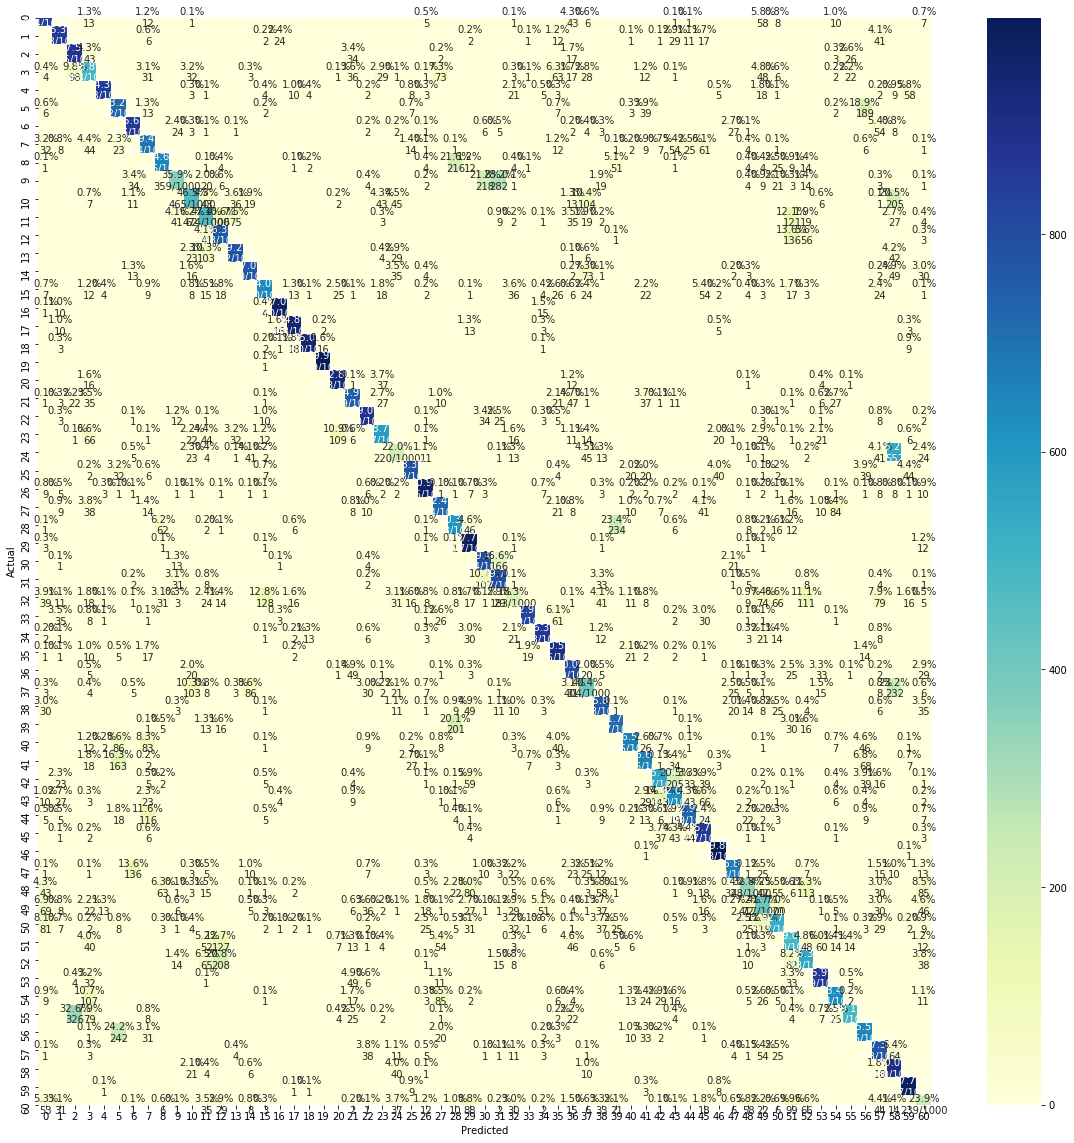

In [16]:
plot_cm(y_true=y_train, y_pred=train_predict)

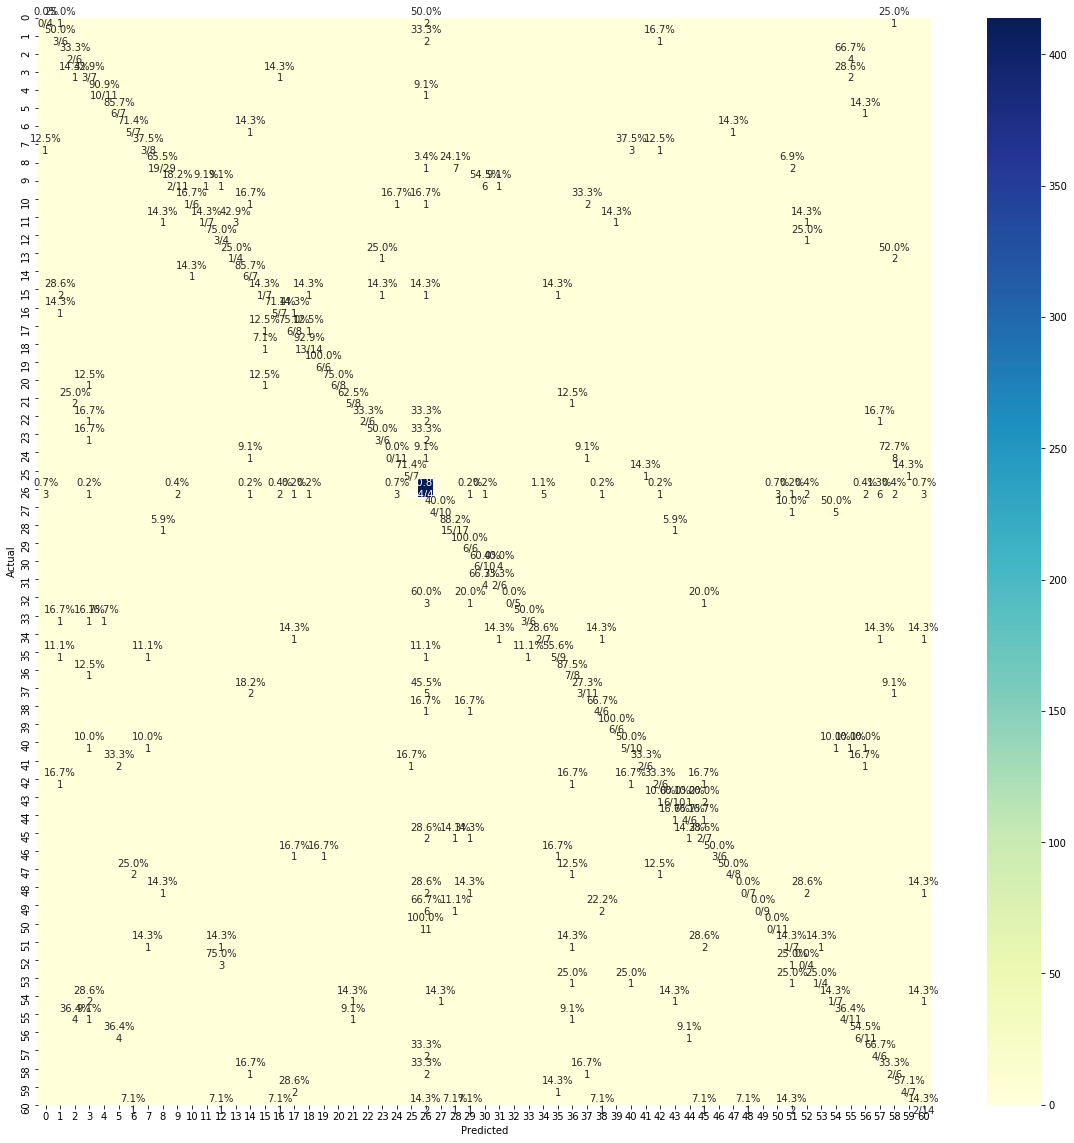

In [17]:
plot_cm(y_true=y_val, y_pred=val_predict)

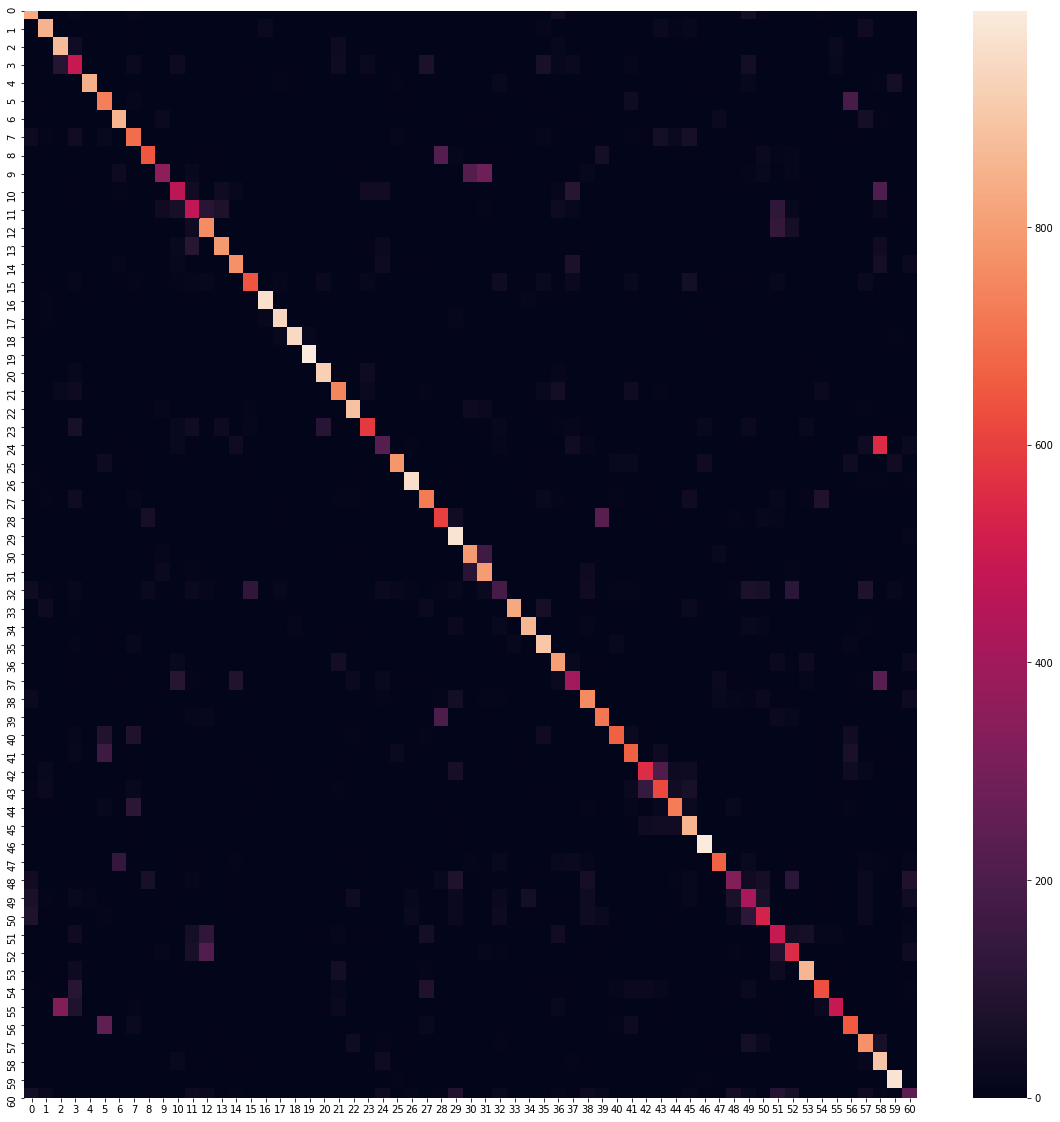

In [18]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_train, train_predict), ax=ax)
plt.show()

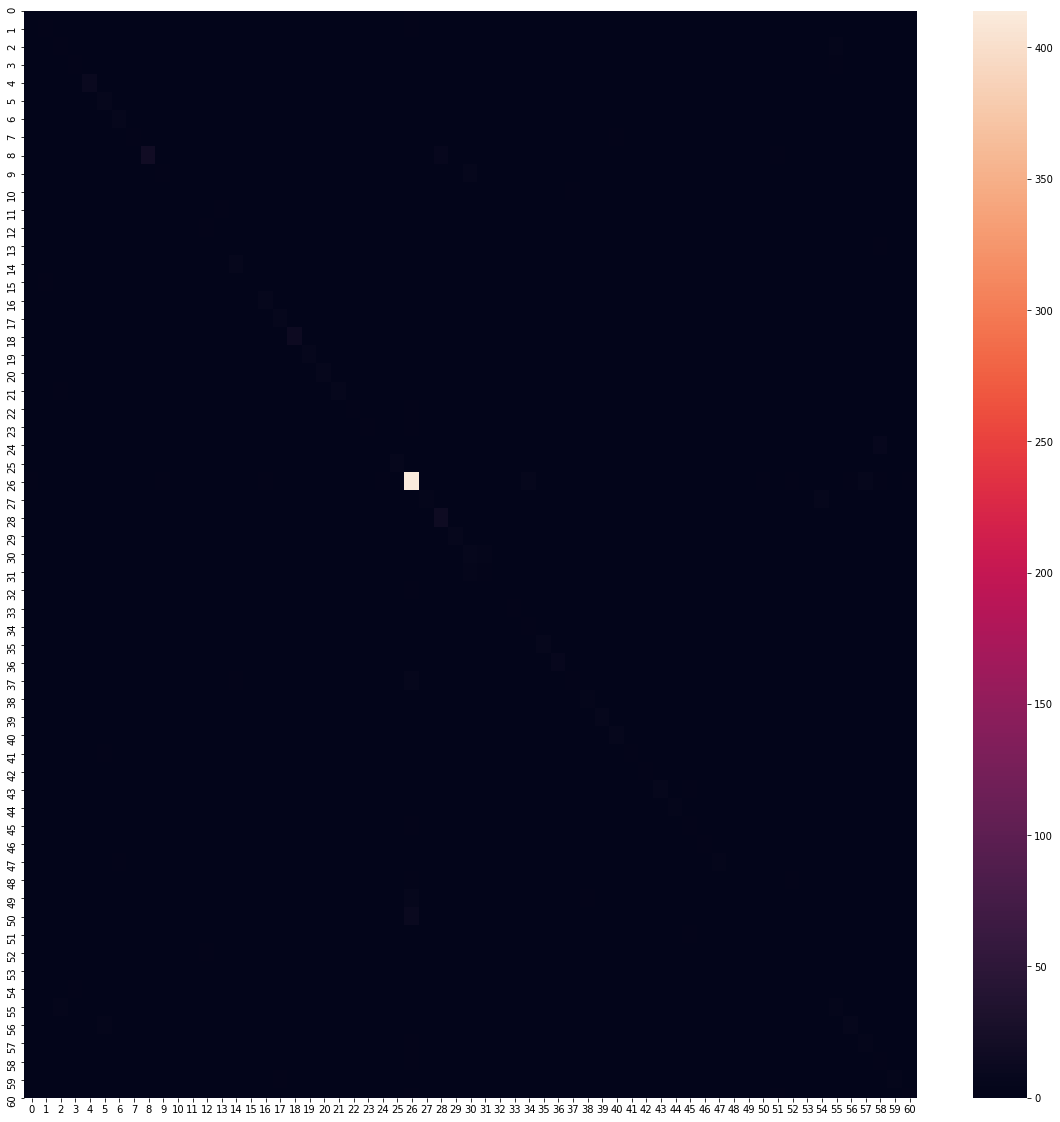

In [19]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_val, val_predict), ax=ax)
plt.show()

# Remove Label 26

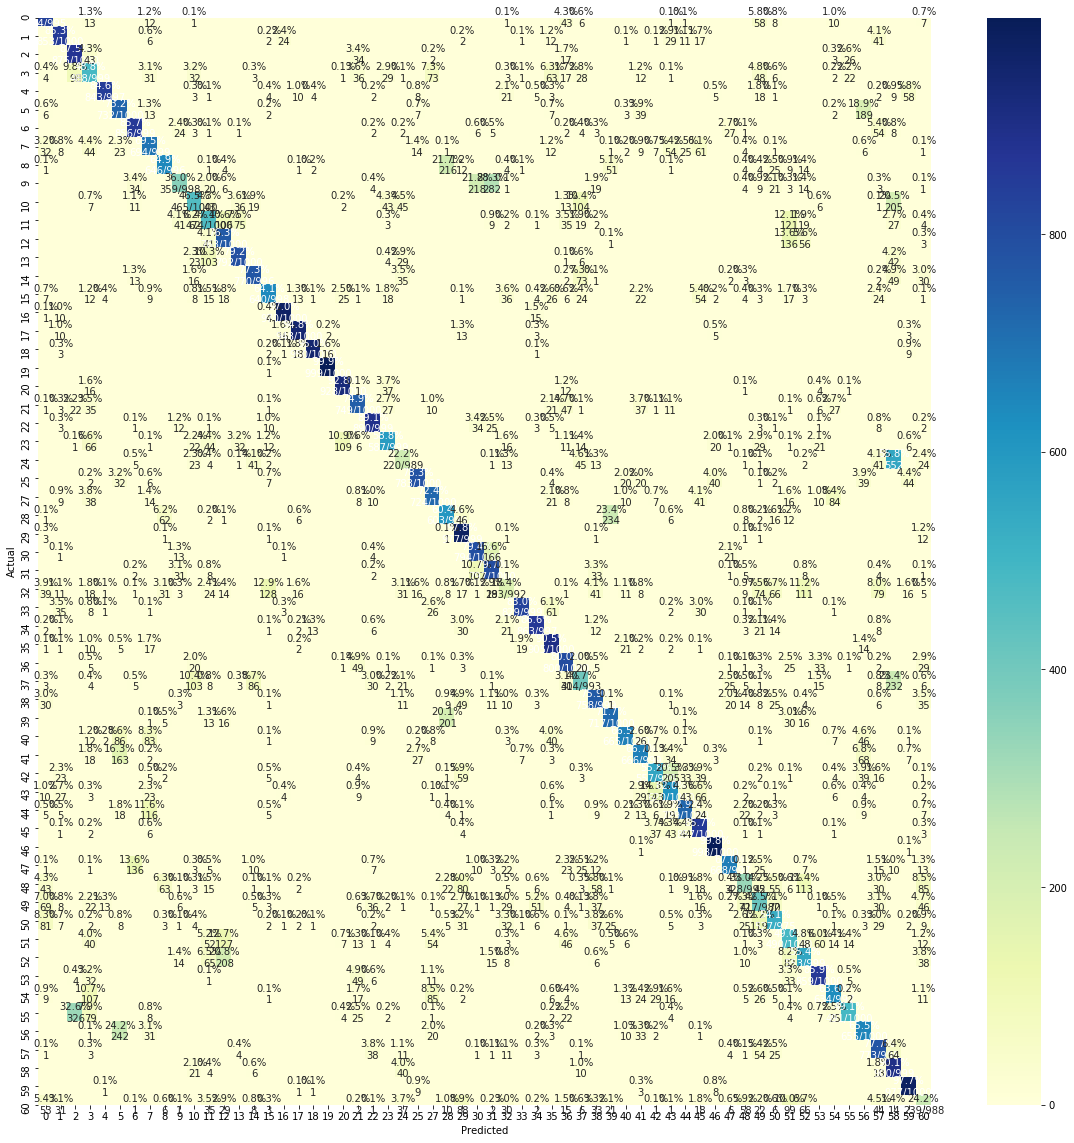

In [20]:
plot_cm(y_true=y_train[y_train!=26], y_pred=train_predict[y_train!=26])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


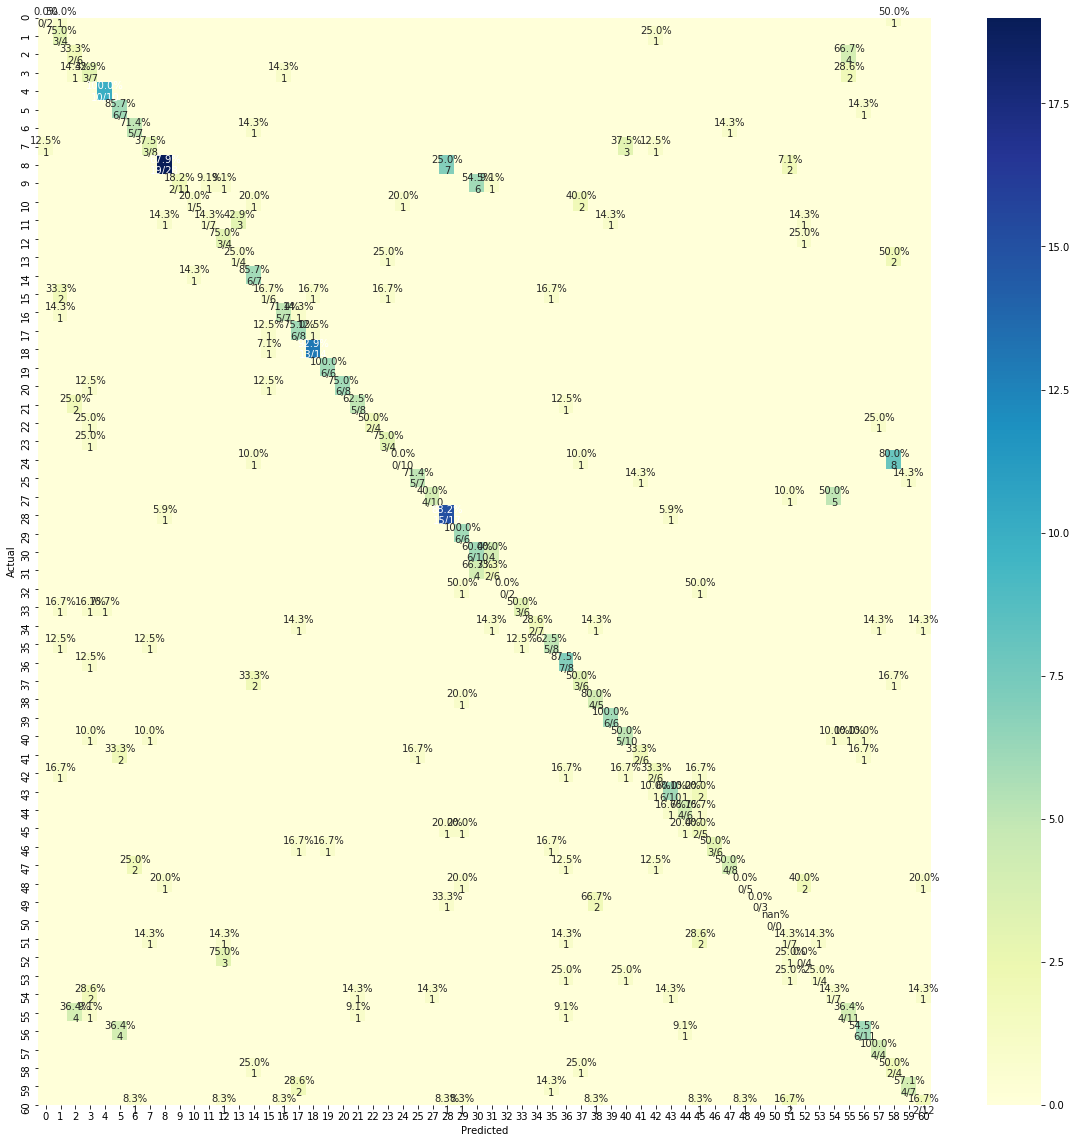

In [21]:
plot_cm(y_true=y_val[y_val!=26], y_pred=val_predict[y_val!=26])

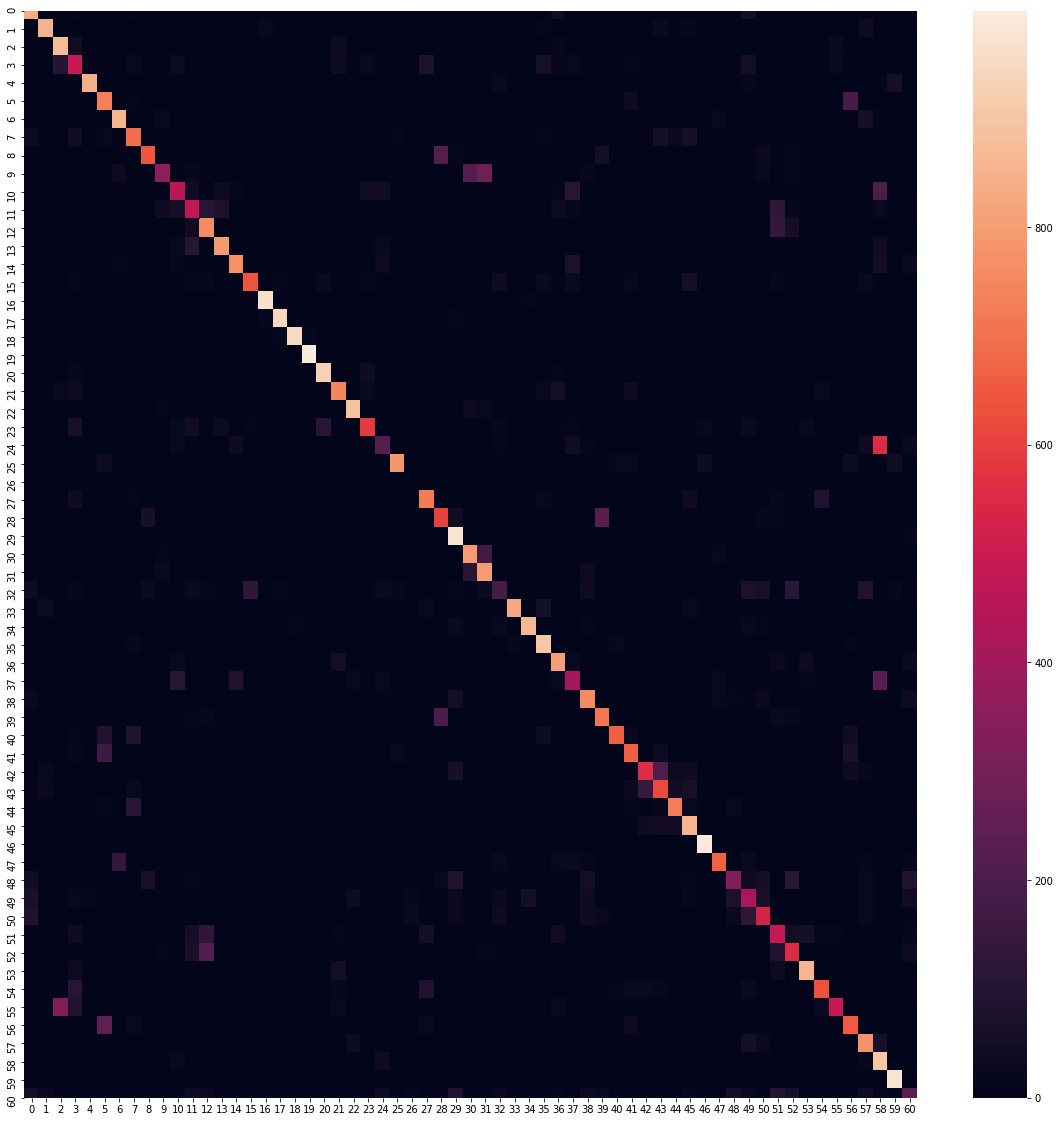

In [22]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_train[y_train!=26], train_predict[y_train!=26]), ax=ax)
plt.show()

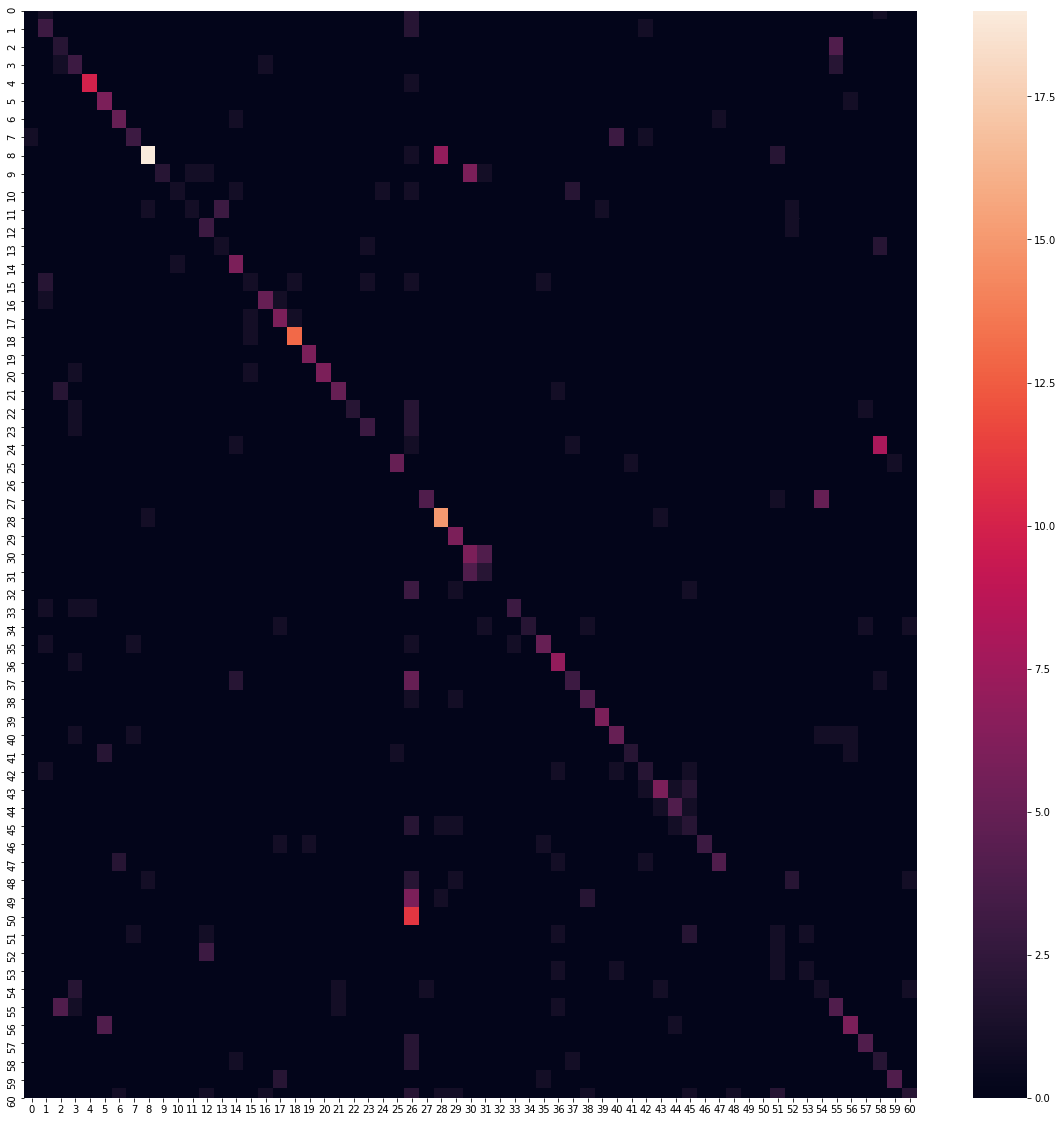

In [23]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix(y_val[y_val!=26], val_predict[y_val!=26]), ax=ax)
plt.show()